RCNNを用いた分類

In [10]:
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout,SimpleRNN
from keras.models          import Model
from keras.layers.wrappers import Bidirectional 
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
import keras.backend as K
from keras.layers.core import Flatten
import random
import sys
import pickle
import glob
import copy
import os
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

In [11]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
addDict={}
seq_len=13
categories=6

In [13]:
def predictVector(word, around_words_list):
    global addDict
    if word in addDict:
        return addDict[word]
    else:
        return addUnknownWord(word,around_words_list)

def addUnknownWord(word , around_words_list):
    global addDict
    rand_vector=np.random.rand(200)/np.linalg.norm(np.random.rand(200))*(10+ 3*np.random.rand(1))
    vector=np.array(model[model.predict_output_word(around_words_list)[0][0]])+rand_vector
    addDict[word]=vector
    return vector
    
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return [word for word in words if word!="「" and word!="」" and word!="、"and word!="。"
            and word!="!" and word!="?"]

def seq2vecs(words,predict):
    global addDict
    vectors=[]
    for i in range(len(words)):
            try:
                vectors.append(model[words[i]])
            except:
                if predict:
                    try:
                        vectors.append(predictVector(words[i],[words[i-1]]))
                    except:
                        if i==0:
                            continue
                        else:
                            similar_word=model.similar_by_vector(addDict[words[i-1]], topn=10, restrict_vocab=None)[0][0]
                            vectors.append(predictVector(words[i],[similar_word]))
                else:
                    return []
    return vectors

def train_test_divide(X,Y,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    return (X_train,Y_train),(X_test,Y_test)

def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

def load_file(filename):
    ttl=[]
    cat=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            ttl.append(title)
            cat.append(int(category))
    ttl,cat=shuffle(ttl,cat)
    ttl=np.array(ttl)
    cat=np.array(cat)
    print(ttl.shape)
    print(cat.shape)
    return ttl,cat
def create_data(ttl,cat,predict,sfl):
    X=[]
    Y=[]
    T=[]
    sum=0
    max_len=0
    min_len=1000000
    for i in range(len(ttl)):
        title=ttl[i]
        category=cat[i]
        words=Wakati(title)
        input_vectors=seq2vecs(words,predict)
        sum+=len(input_vectors)
        max_len=max(max_len,len(input_vectors))
        if len(input_vectors) > seq_len:
            input_vectors=input_vectors[:seq_len]
        elif len(input_vectors)==0:
            continue
        min_len=min(min_len,len(input_vectors))
        if sfl:
            random.shuffle(input_vectors)
        x = [ [0.]*200 for _ in range(seq_len) ]
        x[0:len(input_vectors)]=input_vectors
        y=onehot_vector(int(category))
        X.append(np.array(x))
        Y.append(np.array(y))
        T.append(title)
    X=np.array(X)
    Y=np.array(Y)
    print("-------DataShape------")
    print(X.shape)
    print(Y.shape)
    print(len(T))
    print("-------DataProperties------")
    print("max:"+str(max_len))
    print("min:"+str(min_len))
    print("mean:"+str(sum/len(T)))
    return X,Y,T
def load_dataset(filename,sfl):
    global seq_len
    ttl,cat=load_file(filename)
    if filename=="./data/livedoor_data.txt":
        print("file: livedoor")
        X_test,Y_test,T_test=create_data(ttl,cat,predict=True,sfl=False)
        return X_test,Y_test,T_test
    else:
        print("file: Yahoo")
        (train_ttl,train_cat),(test_ttl,test_cat)=train_test_divide(ttl,cat,0.1)
        X_train,Y_train,T_train=create_data(train_ttl,train_cat,predict=False,sfl=False)
        X_test,Y_test,T_test=create_data(test_ttl,test_cat,predict=True,sfl=False)
        return (X_train,Y_train,T_train),(X_test,Y_test,T_test)
    
(X_train,Y_train,T_train),(X_test,Y_test,T_test)=load_dataset("./data/yahoo_data.txt"
                                                              ,sfl=False)    

(83999,)
(83999,)
file: Yahoo
(75600,)
(75600,)
(8399,)
(8399,)


/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


-------DataShape------
(61452, 13, 200)
(61452, 6)
61452
-------DataProperties------
max:12
min:2
mean:6.1622404478292


/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/gensim/models/word2vec.py:1463: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")
/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).


-------DataShape------
(8399, 13, 200)
(8399, 6)
8399
-------DataProperties------
max:12
min:2
mean:6.021431122752709


In [14]:
inputs      = Input(shape=(seq_len, 200))
x           = Bidirectional(SimpleRNN(200,return_sequences=True),name="encoder")(inputs)
x           = MaxPooling1D(pool_size=seq_len, strides=1, padding='valid')(x)
x           = Flatten(name="pooled")(x)
x           = Dense(256,activation='relu')(x)
x           = Dense(128,activation='relu')(x)
decoded     = Dense(categories,activation='softmax')(x)
model = Model(inputs=inputs, outputs=decoded)
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
history =model.fit(X_train,Y_train,shuffle=True,batch_size=30,epochs=3,
                   validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13, 200)           0         
_________________________________________________________________
encoder (Bidirectional)      (None, 13, 400)           160400    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 400)            0         
_________________________________________________________________
pooled (Flatten)             (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total para

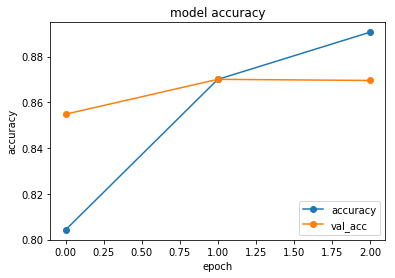

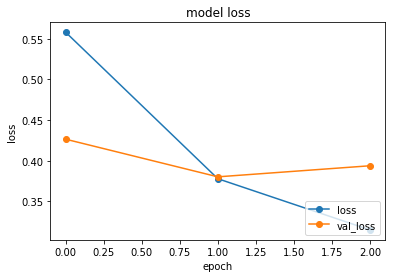

In [15]:
plot_history(history)

In [17]:
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))

8399/8399 [==============================] - 2s 213us/step

loss:0.5651130349682348 accuracy:0.8284319563200963
